In [1]:
import functools
import itertools
import warnings
import skimage
import skimage.restoration.uft
import scipy.ndimage
import numpy as np
import pathlib
import sys
sys.path.insert(0, "../controller")
import tile_configuration
import imageio as iio
import matplotlib.pyplot as plt



In [2]:

# Pre-calculate the Laplacian operator kernel. We'll always be using 2D images.
_laplace_kernel = skimage.restoration.uft.laplacian(2, (3, 3))[1]

def whiten(img, sigma):
    img = skimage.img_as_float32(img)
    if sigma == 0:
        output = scipy.ndimage.convolve(img, _laplace_kernel)
    else:
        output = scipy.ndimage.gaussian_laplace(img, sigma)
    return output


@functools.lru_cache
def get_window(shape):
    # Build a 2D Hann window by taking the outer product of two 1-D windows.
    wy = np.hanning(shape[0]).astype(np.float32)
    wx = np.hanning(shape[1]).astype(np.float32)
    window = np.outer(wy, wx)
    return window


def window(img):
    assert img.ndim == 2
    return img * get_window(img.shape)


def register(img1, img2, sigma, upsample=10):
    img1w = window(whiten(img1, sigma))
    img2w = window(whiten(img2, sigma))

    shift = skimage.registration.phase_cross_correlation(
        img1w,
        img2w,
        upsample_factor=upsample,
        normalization=None
    )[0]

        # At this point we may have a shift in the wrong quadrant since the FFT
    # assumes the signal is periodic. We test all four possibilities and return
    # the shift that gives the highest direct correlation (sum of products).
    shape = np.array(img1.shape)
    shift_pos = (shift + shape) % shape
    shift_neg = shift_pos - shape
    shifts = list(itertools.product(*zip(shift_pos, shift_neg)))
    correlations = [
        np.abs(np.sum(img1w * scipy.ndimage.shift(img2w, s, order=0)))
        for s in shifts
    ]
    idx = np.argmax(correlations)
    shift = shifts[idx]
    correlation = correlations[idx]
    total_amplitude = np.linalg.norm(img1w) * np.linalg.norm(img2w)
    if correlation > 0 and total_amplitude > 0:
        error = -np.log(correlation / total_amplitude)
    else:
        error = np.inf
    return shift, error


def nccw(img1, img2, sigma):
    img1w = whiten(img1, sigma)
    img2w = whiten(img2, sigma)
    correlation = np.abs(np.sum(img1w * img2w))
    total_amplitude = np.linalg.norm(img1w) * np.linalg.norm(img2w)
    if correlation > 0 and total_amplitude > 0:
        diff = correlation - total_amplitude
        if diff <= 0:
            error = -np.log(correlation / total_amplitude)
        elif diff < 1e-5:
            # This situation can occur due to numerical precision issues when
            # img1 and img2 are very nearly or exactly identical. If the
            # difference is small enough, let it slide.
            error = 0
        else:
            raise RuntimeError(
                f"correlation > total_amplitude (diff={diff})"
            )
    else:
        error = np.inf
    return error


def crop(img, offset, shape):
    # Note that this only crops to the nearest whole-pixel offset.
    start = offset.round().astype(int)
    end = start + shape
    img = img[start[0]:end[0], start[1]:end[1]]
    return img


# TODO:
# - Deal with ringing from high-frequency elements. The wrapped edges of the
#   image are especially bad, where the wrapping introduces sharp
#   discontinuities. The edge artifacts could be dealt with in several ways
#   (extend the trailing image edge via mirroring, throw away some of the
#   trailing edge of the shifted result) but edges in the "true" image content
#   would require proper pre-filtering. What filter to use, and how to apply it
#   quickly?
# - Can we use real FFT for a ~50% overall speedup? Fourier-space matrices will
#   all be half-size in the last dimension, so FFT is around 50% faster and our
#   fshift calculations will be too.
# - Trailing edge pixels should be zeroed to match the behavior of
#   scipy.ndimage.shift, which we rely on in our maximum-intensity projection.
def fourier_shift(img, shift):
    # Ensure properly aligned complex64 data (fft requires complex to avoid
    # reallocation and copying).
    img = skimage.util.img_as_float32(img)
    img = pyfftw.byte_align(img, dtype=np.complex64)
    # Compute per-axis frequency values according to the Fourier shift theorem.
    # (Read "w" here as "omega".) We pre-multiply as many scalar values as
    # possible on these vectors to avoid operations on the full w matrix below.
    v = np.fft.fftfreq(img.shape[0])
    wy = (2 * np.pi * v * shift[0]).astype(np.float32).reshape(-1, 1)
    u = np.fft.fftfreq(img.shape[1])
    wx = (2 * np.pi * u * shift[1]).astype(np.float32)
    # Add column and row vector to get full expanded matrix of frequencies.
    w = wy + wx
    # We perform an explicit application of Euler's formula with careful
    # management of output arrays to avoid extra memory allocations and copies,
    # squeezing out some speed over the obvious np.exp(-1j*w).
    fshift = np.empty_like(img, dtype=np.complex64)
    np.cos(w, out=fshift.real)
    np.sin(w, out=fshift.imag)
    np.negative(fshift.imag, out=fshift.imag)
    # Perform the FFT, multiply in-place by the shift matrix, then IFFT.
    freq = pyfftw.builders.fft2(img, planner_effort='FFTW_ESTIMATE',
                                avoid_copy=True, auto_align_input=True,
                                auto_contiguous=True)()
    freq *= fshift
    img_s = pyfftw.builders.ifft2(freq, planner_effort='FFTW_ESTIMATE',
                                  avoid_copy=True, auto_align_input=True,
                                  auto_contiguous=True)()
    # Any non-zero imaginary component of the resulting array is due to
    # numerical error, so we can just return the real part.
    # FIXME need to zero out row(s) and column(s) we shifted away from,
    # since at this point we have a cyclic rotation rather than a shift.
    return img_s.real


def paste(target, img, pos, func=None):
    """Composite img into target."""
    pos = np.array(pos)
    # Bail out if destination region is out of bounds.
    if np.any(pos >= target.shape[:2]) or np.any(pos + img.shape[:2] < 0):
        return
    pos_f, pos_i = np.modf(pos)
    yi, xi = pos_i.astype('i8')
    # Clip img to the edges of the mosaic.
    if yi < 0:
        img = img[-yi:]
        yi = 0
    if xi < 0:
        img = img[:, -xi:]
        xi = 0
    target_slice = target[yi:yi+img.shape[0], xi:xi+img.shape[1]]
    img = crop_like(img, target_slice)
    # Skip expensive sub-pixel shift if fractional position is zero.
    if pos_f.any():
        if img.ndim == 2:
            img = scipy.ndimage.shift(img, pos_f)
        else:
            for c in range(img.shape[2]):
                img[...,c] = scipy.ndimage.shift(img[...,c], pos_f)
        # For any axis where there is a non-zero subpixel shift, crop out the
        # last row or column of pixels on the "losing" side. These pixels will
        # be darker than normal and will introduce artifacts in most blending
        # modes.
        y1 = None if pos_f[0] <= 0 else 1
        y2 = None if pos_f[0] >= 0 else -1
        x1 = None if pos_f[1] <= 0 else 1
        x2 = None if pos_f[1] >= 0 else -1
        img = img[y1:y2, x1:x2]
        target_slice = target_slice[y1:y2, x1:x2]
        # Exit if image area is zero after subpixel shift.
        if not np.all(img.shape):
            return
    if np.issubdtype(img.dtype, np.floating):
        np.clip(img, 0, 1, img)
    img = dtype_convert(img, target.dtype)
    if func is None:
        target_slice[:] = img
    elif isinstance(func, np.ufunc):
        func(target_slice, img, out=target_slice)
    else:
        target_slice[:] = func(target_slice, img)


def pastefunc_blend(target, img):
    """Linear blend based on distance to unfilled space in target."""
    # This should catch actual holes but not the actual unfilled space.
    # FIXME Should generate mask from tile boundaries instead.
    hole_threshold = np.mean(target.shape)
    mask = skimage.morphology.remove_small_holes(target != 0, hole_threshold)
    dist = scipy.ndimage.distance_transform_cdt(mask)
    dmax = dist.max()
    if dmax == 0:
        alpha = 0
    else:
        alpha = dist / dmax
        # Keep target pixel values where img has value 0 (with a 1-pixel
        # dilation to clean up the edge). This is a temporary hack to support
        # image corrections that leave regions of zero pixels around the edge of
        # img, such as barrel correction and rotation.
        # FIXME Should compute the geometry of the source image mask more
        # deliberately and precisely.
        alpha[skimage.morphology.binary_dilation(img == 0)] = 1
    return target * alpha + img * (1 - alpha)


def crop_like(img, target):
    if (img.shape[0] > target.shape[0]):
        img = img[:target.shape[0], :]
    if (img.shape[1] > target.shape[1]):
        img = img[:, :target.shape[1]]
    return img


def dtype_convert(img, dtype):
    """Convert an image to the requested data-type.

    This is just a wrapper around skimage.util.dtype.convert that silences its
    FutureWarning, as Ashlar pins skimage to a version before that planned
    deprecation.

    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", r".*scikit-image 1\.0", FutureWarning)
        return skimage.util.dtype.convert(img, dtype)


def imsave(fname, arr, **kwargs):
    """Save an image to file.

    This is a wrapper around skimage.io.imsave to force check_contrast=False
    since the contrast check kills us on the huge images we create.

    """

    if "check_contrast" in kwargs:
        warnings.warn("ignoring check_contrast argument -- forcing to False")
    kwargs["check_contrast"] = False

    # We use scikit-image's vendored copy of tifffile directly rather than allow
    # scikit-image to optimistically use a separately-installed copy of tifffile
    # due to bugs and API inconsistencies in the latest pypi-hosted version:
    # * Use of "centimeter" for resolution units instead of "cm"
    # * A bug in writing single-tile planes -- issue #3 on GitHub
    # FIXME Once scikit-image un-vendors tifffile (#4235) AND tifffile fixes #3
    # we can remove this block and use `skimage.io.imsave` directly again. Or we
    # might just want to switch to tifffile.imsave.
    del kwargs["check_contrast"]
    import skimage.external.tifffile
    skimage.external.tifffile.imsave(fname, arr, **kwargs)

In [3]:

prefix = pathlib.Path(r"C:\Users\davidek\microscope_ui\controller\photo\1732319758.459453")
tc = tile_configuration.TileConfiguration()                   
tc.load(prefix / "TileConfiguration.registered.registered.txt")                  
tc.move_to_origin()

In [4]:

d = {}
for image1 in tc.images:
    i1 = np.asarray(iio.imread(prefix / image1.filename))
    gray = np.dot(i1, [0.2989, 0.5870, 0.1140])
    gray = np.round(gray).astype(np.uint8)
    d[image1.filename] = gray

C:\Users\davidek\AppData\Local\Temp\ipykernel_30880\1192239.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  i1 = np.asarray(iio.imread(prefix / image1.filename))


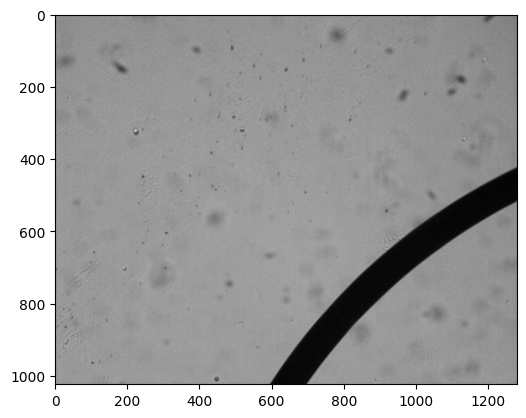

In [ ]:
i = d[list(d)[0]]

plt.imshow(i, cmap='gray')

In [9]:

img1 = d[pathlib.Path('test.1732319760.040808.jpg')]
img2 = d[pathlib.Path('test.1732319761.527621.jpg')]


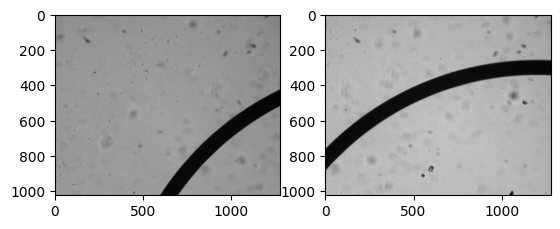

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

#register(img1, img2, sigma=0.01)

In [24]:
sigma=1
img1w = whiten(img1, sigma)
img2w = whiten(img2, sigma)
print(np.var(img1w))

2.3041786e-05


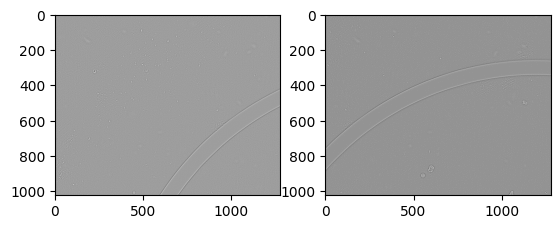

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1w, cmap='gray')
ax[1].imshow(img2w, cmap='gray')


In [14]:
register(img1, img2, sigma=1)

((0.10000000149011612, 0.0), 2.636161)